In [2]:

import sys
sys.path.append('../../')

import os
os.environ['PYTHONPATH'] = '../..'

base_url = 'D:\ESI\\3CS\PFE\last_year\Code\MEDfl'



In [10]:
!python "../../scripts/create_db.py" "../../notebooks/data/masterDataSet/Mimic_ouael.csv"

Im here !


In [2]:
from MEDfl.LearningManager.utils import *
from MEDfl.NetManager.database_connector import DatabaseManager

set_db_config('../../scripts/db_config.ini')

db_manager = DatabaseManager()
db_manager.connect()
db_manager.get_connection()

print('getting connection')


C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


getting connection


In [3]:
load_db_config()

{'host': 'localhost',
 'port': '3306',
 'user': 'root',
 'password': '',
 'database': 'MEDfl'}

In [3]:
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine,text
import subprocess


# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


## MEDfl Imports 
## Network Manager Imports 
from MEDfl.NetManager.node import Node
from MEDfl.NetManager.network import Network
from MEDfl.NetManager.dataset import DataSet
from MEDfl.NetManager.flsetup import FLsetup

# flower imports 
import flwr as fl

## Learning Manager imports 
from MEDfl.LearningManager.dynamicModal import DynamicModel
from MEDfl.LearningManager.model import Model
from MEDfl.LearningManager.strategy import Strategy
from MEDfl.LearningManager.server import *
from MEDfl.LearningManager.flpipeline import *
from MEDfl.LearningManager.plot import AccuracyLossPlotter




# Utils
from MEDfl.LearningManager.utils import *


2024-04-23 20:50:11,068	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [4]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, num_layers, layer_size):
        super(BinaryClassifier, self).__init__()

        # Input layer
        self.layers = [nn.Linear(input_size, layer_size)]
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(layer_size, layer_size))
        
        # Output layer
        self.layers.append(nn.Linear(layer_size, 1))
        
        # ModuleList to handle dynamic number of layers
        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        return x

In [5]:
centralized_score = 0.7774

In [6]:
# Best HyperParams using optuna optimisation 
best_hyperparams = {'batch_size': 16, 'num_layers': 6, 'hidden_size': 46,
                    'optimizer': 'RMSprop', 'learning_rate': 0.0019940796634093597, 'num_epochs': 1}

In [7]:
#  Best threshold
best_th = 0.3

In [8]:
# The number of server rounds
n_rounds = [1]

In [9]:
benchmarks_config = {
    # * 1 . Differential Privacy
    # *******************************************
    "diff_privacy": [
        {
            # DP config
            "dp_activate": False,

            # The rest of the config
            "n_clients": 10,
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # DP config
            "dp_activate": True,
            "DELTA": 1e-5,
            "EPSILON": 5.0,

            # The rest of the config
            "n_clients": 10,
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # DP config
            "dp_activate": True,
            "DELTA": 1e-5,
            "EPSILON": 10.0,

            # The rest of the config
            "n_clients": 10,
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # DP config
            "dp_activate": True,
            "DELTA": 1e-5,
            "EPSILON": 0.5,

            # The rest of the config
            "n_clients": 10,
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # DP config
            "dp_activate": True,
            "DELTA": 0,
            "EPSILON": 0.5,

            # The rest of the config
            "n_clients": 10,
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
              {
            # DP config
            "dp_activate": True,
            "DELTA": 0,
            "EPSILON": 5.0,

            # The rest of the config
            "n_clients": 10,
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        }
    ],
    # * 2 . Nodes Config
    # *******************************************
    "nodes_config": [
        {
            # nodes config
            "train_test": True,
            "train_portion": 0.5,

            # The rest of the config
            "n_clients": 10,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # nodes config
            "train_test": True,
            "train_portion": 0.7,

            # The rest of the config
            "n_clients": 10,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # nodes config
            "train_test": False,
            "train_portion": 0.5,

            # The rest of the config
            "n_clients": 10,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # nodes config
            "train_test": False,
            "train_portion": 0.7,

            # The rest of the config
            "n_clients": 10,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
    ],
    # * 3 . Aggregation Algorithm
    # *******************************************
    "Aggreg_algo": [
        {
            # Aggregation alrogithm
            "aggreg_algo": "FedAvg",

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "n_clients": 10,
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Aggregation alrogithm
            "aggreg_algo": "FedYogy",

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "n_clients": 10,
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Aggregation alrogithm
            "aggreg_algo": "FedAdaGrad",

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "n_clients": 10,
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Aggregation alro100githm
            "aggreg_algo": "FedAdam",

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "n_clients": 10,
            "dp_activate": False,
            "Tl": True,
        },
    ],
    # * 4 . Aggregation Algorithm
    # *******************************************
    "n_clients": [
        {
            # Number of clients
            "n_clients": 5,

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Number of clients
            "n_clients": 10,

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Number of clients
            "n_clients": 30,

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "dp_activate": False,
            "Tl": True,
        },

    ],
    # * 5 . Combine the configurations 
    # *******************************************
    "combined_config": []
}

In [11]:
# Benchmarks_result stors the result of each configuration in the benchmark 
benchmarks_results = []

In [12]:
# a fuction to test if the config is already tested
def is_config_tested(config , n_rounds):
    for result in benchmarks_results:
        if result['config'] == config and n_rounds == result['n_rounds'] : return True
    
    return False 

In [13]:
import pandas as pd
import os

def split_csv(input_file, output_directory, n):
    """
  
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    else:
        # Clean the output directory by removing existing files
        for file in os.listdir(output_directory):
            file_path = os.path.join(output_directory, file)
            if os.path.isfile(file_path):
                os.remove(file_path)

    # Read the CSV file into a DataFrame
    df = pd.read_csv(input_file)

    # Calculate the number of rows in each part
    rows_per_part = len(df) // n

    # Split the DataFrame into n parts
    split_dataframes = [df.iloc[i*rows_per_part:(i+1)*rows_per_part] for i in range(n-1)]
    split_dataframes.append(df.iloc[(n-1)*rows_per_part:])

    # Save each part to a separate CSV file
    output_files = []
    for i, split_df in enumerate(split_dataframes):
        output_file = os.path.join(output_directory, f"output_{i+1}.csv")
        split_df.to_csv(output_file, index=False)
        output_files.append(output_file)

    return output_files

# Example usage:
input_csv = '../data/masterDataSet/Mimic_ouael.csv'
output_dir = '../data/nodesData'

In [14]:
import yaml

def update_yaml_file(file_path, param_name, new_value):
    """
    Update a parameter in a YAML file.
    
    Args:
        file_path (str): Path to the YAML file.
        param_name (str): Name of the parameter to update.
        new_value: New value for the parameter.
    """
    # Load YAML file into a dictionary
    with open(file_path, 'r') as file:
        yaml_data = yaml.safe_load(file)
    
    # Update the parameter value
    if param_name in yaml_data:
        yaml_data[param_name] = new_value
    else:
        print(f"Parameter '{param_name}' not found in the YAML file.")
        return
    
    # Save the updated dictionary back to the YAML file
    with open(file_path, 'w') as file:
        yaml.dump(yaml_data, file)





In [15]:
import os

def count_files_in_directory(directory):
    """
    Count the number of files in a directory.
    
    Args:
        directory (str): Path to the directory.
    
    Returns:
        int: Number of files in the directory.
    """
    # Initialize count
    file_count = 0
    
    # Iterate over files in the directory
    for _, _, files in os.walk(directory):
        file_count += len(files)
    
    return file_count



In [16]:
device = torch.device(
            f"cuda" if torch.cuda.is_available() else "cpu"
        )

In [ ]:

# Loop Over the benchmark configs
for key in benchmarks_config.keys():
    print("Executing the: " + key + " configurations")
    for config in benchmarks_config[key]:
        print("Executing th confuguration")
        print(config)
        for server_rounds in n_rounds:
            if(is_config_tested(config=config , n_rounds=server_rounds)):
                break
            # Create the MEDfl pipeline for each config

            

            db_manager.create_MEDfl_db(path_to_csv="../data/masterDataSet/Mimic_ouael.csv")

            # if the differential privac is activated change the epsilon and delta on the params file 
            if(config["dp_activate"]):
                update_yaml_file(base_url + "/MEDfl/LearningManager/params.yaml", "EPSILON", config['EPSILON'])
                update_yaml_file(base_url + "/MEDfl/LearningManager/params.yaml", "DELTA", config['DELTA'])
            

            
            # Create a nest work "Net_1"
            Net_1 = Network(name="manual_network_2")
            Net_1.create_network()

            # Create a MasterDataSet from Net_1
            Net_1.create_master_dataset("../data/masterDataSet/Mimic_ouael.csv")

            # auto FLsetup creation
            autoFl = FLsetup(name="Flsetup_2",
                             description="The second fl setup", network=Net_1)
            autoFl.create()

            # Spilt master Dataset on n part (n number of clients )
            if(count_files_in_directory(output_dir) != config['n_clients']):
                split_files = split_csv(input_csv, output_dir, config['n_clients'])

            # Create Nodes
            if (config['train_test']):
                n_train = int(config['n_clients']*config['train_portion']) + 1

                #  Create the Train nodes
                for i in range(1, 1 + n_train):
                    hospital = Node(name="hospital_"+str(i), train=1)
                    Net_1.add_node(hospital)
                    hospital.upload_dataset(
                        "hospital_"+str(i)+'_dataset', base_url + '/notebooks/data/nodesData/output_'+str(i)+'.csv')

                #  Create the test nodes
                for i in range(1 + n_train, config['n_clients'] + 1):
                    hospital = Node(name="hospital_"+str(40+i), train=0)
                    Net_1.add_node(hospital)
                    hospital.upload_dataset("hospital_"+str(40+i)+'_dataset',
                                            base_url + '/notebooks/data/nodesData/output_'+str(i)+'.csv')

                #  Create a test+train nodes
                else:
                    pass

            # Create FLDataSet
            fl_dataset = autoFl.create_federated_dataset(
                output="deceased",
                fit_encode=[],
                to_drop=["deceased"]
            )

            if (config['Tl']):
                # Load the pretrained model
                model = Model.load_model(
                    "../../notebooks/.ipynb_checkpoints/trainedModels/grid_search_classifier.pth")
            else:
                # Create the model with the suggested hyperparameters
                model = BinaryClassifier(input_size=fl_dataset.size,
                                         num_layers=best_hyperparams['num_layers'],
                                         layer_size=best_hyperparams['hidden_size'],)
           

            # Pass the specific_model to the Model class
            if best_hyperparams['optimizer'] == 'Adam':
                optimizer = optim.Adam(
                    model.parameters(), lr=best_hyperparams['learning_rate'])
            elif best_hyperparams['optimizer'] == 'SGD':
                optimizer = optim.SGD(model.parameters(),
                                      lr=best_hyperparams['learning_rate'])
            elif best_hyperparams['optimizer'] == 'RMSprop':
                optimizer = optim.RMSprop(
                    model.parameters(), lr=best_hyperparams['learning_rate'])

            # Define loss function and optimizer

            pos_weight = torch.tensor([(1 - best_th) / best_th])
            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

            # Creating a new Model instance using the specific model created by DynamicModel
            global_model = Model(model, optimizer, criterion)

            # Get the initial params of the model
            init_params = global_model.get_parameters()

            # Create the strategy
            aggreg_algo = Strategy(config['aggreg_algo'],
                                   fraction_fit=1.0,
                                   fraction_evaluate=1.0,
                                   min_fit_clients=2,
                                   min_evaluate_clients=2,
                                   min_available_clients=2,
                                   initial_parameters=global_model.get_parameters())
            aggreg_algo.create_strategy()

            # Create The server
            server = FlowerServer(global_model,
                                  strategy=aggreg_algo,
                                  num_rounds=server_rounds,
                                  num_clients=len(fl_dataset.trainloaders),
                                  fed_dataset=fl_dataset,
                                  diff_privacy=config['dp_activate'],
                                  # You can change the resources alocated for each client based on your machine
                                  client_resources={
                                      'num_cpus': 1.0, 'num_gpus': 0.0}
                                  )
            # Create the pipeline
            ppl_1 = FLpipeline(name="the second fl_pipeline",
                               description="this is our first FL pipeline",
                               server=server)
            
            # Run the Traning of the model
            history = ppl_1.server.run()

            # Test the model 
            report = ppl_1.auto_test()
            
            #  Print the results of the config 
            print('\n\n--------------------------------------------------- \n\n')
            print(config)
            print(server_rounds)
            print(server.auc)
            print(report)
            print('\n\n --------------------------------------------------- \n\n')

            # Save the results in a txt file 
            with open('benchmarks_results.txt', 'a') as file:
                # Write the results in the txt file
                file.write('\n\n---------------------------------------------------\n\n')
                file.write(str(config) + '\n')
                file.write(str(server_rounds) + '\n')
                file.write(str(server.auc) + '\n')
                file.write('\n\n---------------------------------------------------\n\n')

            
            # store the results 
            benchmarks_results.append({
                'n_rounds' : server_rounds,
                'config' : config , 
                'results' : server.auc,
                'test_results' : report
            })


In [ ]:
print(benchmarks_results)

[{'n_rounds': 50, 'config': {'Tl': True, 'train_test': True, 'train_portion': 0.5, 'aggreg_algo': 'FedAvg', 'dp_activate': False, 'n_clients': 10}, 'results': [0.5338997422330756, 0.5274894858228192, 0.5210792294125627, 0.5210792294125627, 0.5146689730023063, 0.5146689730023063, 0.5455331705331705, 0.5146689730023063, 0.5455331705331705, 0.5455331705331705, 0.5519434269434269, 0.5455331705331705, 0.5455331705331705, 0.5455331705331705, 0.5455331705331705, 0.5455331705331705, 0.5455331705331705, 0.5455331705331705, 0.5519434269434269, 0.5455331705331705, 0.5398188848188847, 0.5398188848188847, 0.5398188848188847, 0.5626760276760276, 0.5861803011803012, 0.5626760276760276, 0.5701546601546602, 0.5651451634784967, 0.5614516347849681, 0.56335639668973, 0.5614516347849681, 0.5838875322208655, 0.5662135395468728, 0.54335639668973, 0.5651451634784967, 0.5662135395468728, 0.5905541988875321, 0.5808540225206892, 0.5565133631800299, 0.575995115995116, 0.5674481074481075, 0.575995115995116, 0.5674

In [ ]:
import numpy as np

def get_results_by_categ(benchmarks_results , categ):
    results = []
    try:
        for res in benchmarks_results:
            if(res['config'] in benchmarks_config[categ]):
                results.append(res)
        
        centraized_results = np.full(n_rounds[0], centralized_score)
        results.append({
            "config" : {"MODE"  : "centralized"},
            "results" : centraized_results
        })
        return results
    except Exception as e :
        print(e)
        print(" Category not found in the benchmarking results")
        return []

    

In [ ]:
import matplotlib.pyplot as plt

def plot_benchmarks_results(benchmarks_results, categ):
    # Sample data
    data = get_results_by_categ(benchmarks_results=benchmarks_results, categ=categ)

    if data and len(data) != 0:
        # Group data by 'config' for separate graphs
        config_groups = {}
        plt.figure()

        for entry in data:
            config = entry['config']
            results = entry['results']
            plt.plot(range(1, len(results) + 1), results, marker='o', label=str(config))

        plt.xlabel('Number of Rounds')
        plt.ylabel('Results')
        plt.title('Results for ' + categ)

        # Place legend outside the plot area
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.grid(True)
        plt.show()
    return


# Number of clients Benchmarks

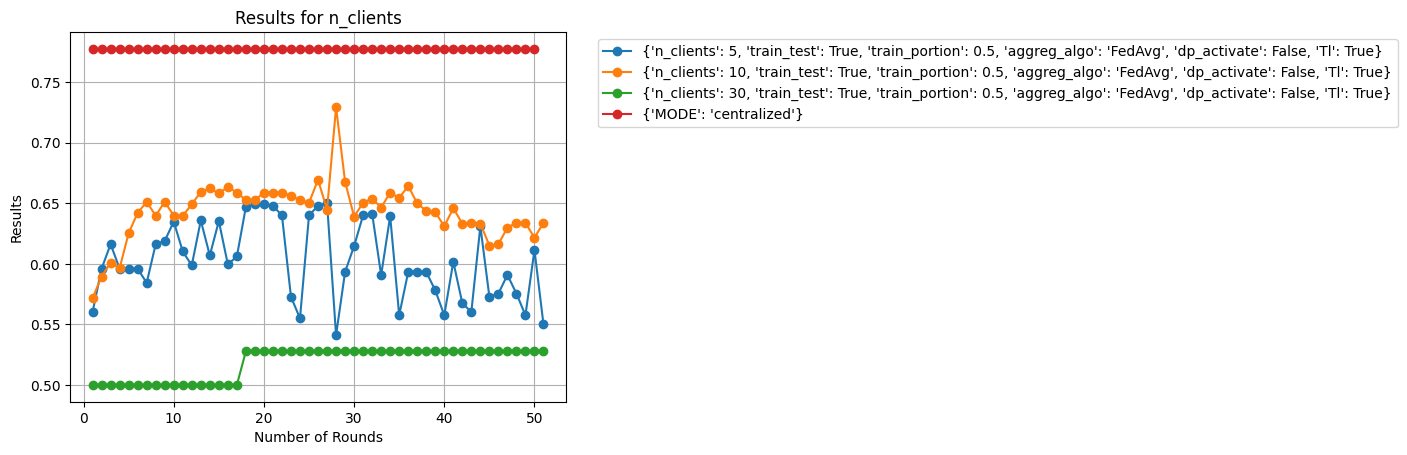

In [ ]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="n_clients" )

# Transfer Learning activation

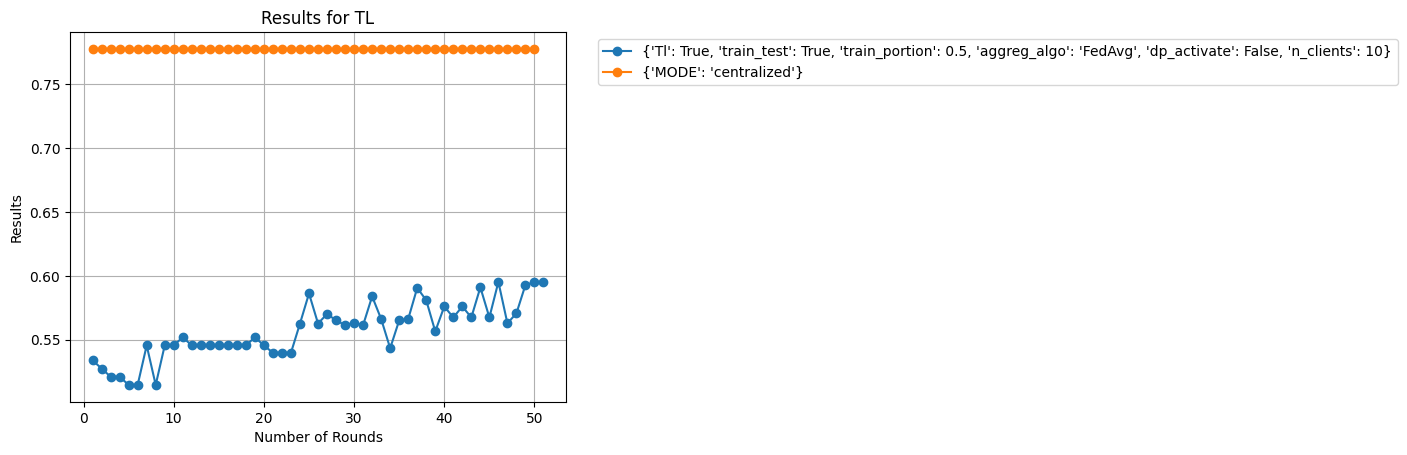

In [ ]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="TL" )